In [7]:
#daylight hours obtained using astral

from datetime import datetime, timedelta
from astral import LocationInfo
from astral.sun import sun
import csv

# Define Sizewell C location
sizewell = LocationInfo("Sizewell", "England", "Europe/London", 52.198, 1.604)

def generate_daylight_windows(start_date, end_date):
    current_date = start_date
    daylight_windows = []

    while current_date <= end_date:
        s = sun(sizewell.observer, date=current_date, tzinfo=sizewell.timezone)
        sunrise = s['sunrise']
        sunset = s['sunset']
        daylight_windows.append((current_date.strftime('%Y-%m-%d'), sunrise.strftime('%H:%M:%S'), sunset.strftime('%H:%M:%S')))
        current_date += timedelta(days=1)

    return daylight_windows

# Generate windows for December 2025
start = datetime(2025, 12, 1)
end = datetime(2025, 12, 31)
windows = generate_daylight_windows(start, end)

# Save to CSV
with open('sizewell_daylight_windows_december_2025.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Date', 'Sunrise', 'Sunset'])
    writer.writerows(windows)

print("CSV file saved successfully.")


CSV file saved successfully.


C:\Users\webbb\AppData\Local\Temp\ipykernel_33460\1663630113.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["DateTime"] = pd.to_datetime(df["DateTime"], errors='coerce')


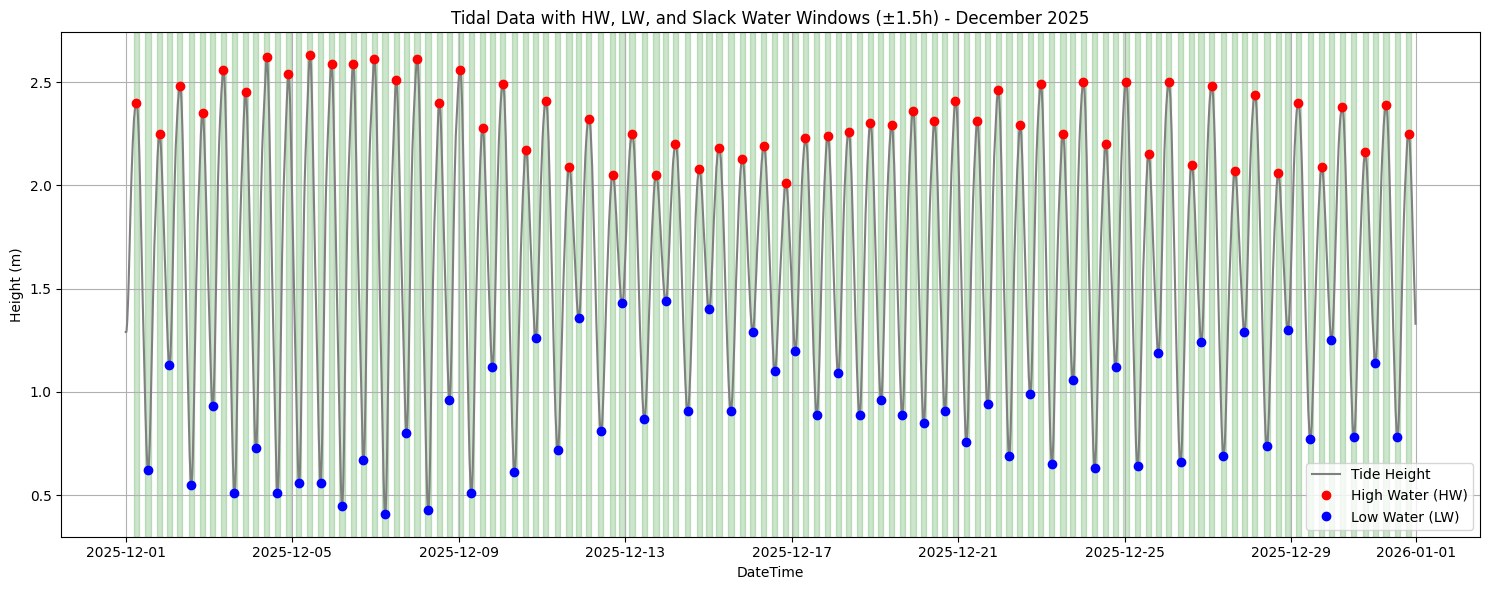

In [8]:
import pandas as pd
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Load the tidal data
file_path = r"C:\Users\webbb\VolkerWessels UK\Grp_VMS GeoSeacore Collaboration Space - SZC\2 Internal WIP\06. MST's\Weather Windows\scripts\Tide Data_Lowestoft_10min.CSV"
df = pd.read_csv(file_path, skiprows=2, names=["DateTime", "Height"])

# Convert columns to appropriate types
df["DateTime"] = pd.to_datetime(df["DateTime"], errors='coerce')
df["Height"] = pd.to_numeric(df["Height"], errors='coerce')
df.dropna(inplace=True)

# Filter for December 2025
df_dec = df[(df["DateTime"].dt.year == 2025) & (df["DateTime"].dt.month == 12)]

# Find High Water (peaks) and Low Water (troughs)
peaks, _ = find_peaks(df_dec["Height"])
troughs, _ = find_peaks(-df_dec["Height"])

# Extract HW and LW times
hw_times = df_dec.iloc[peaks][["DateTime", "Height"]].copy()
hw_times["Type"] = "HW"

lw_times = df_dec.iloc[troughs][["DateTime", "Height"]].copy()
lw_times["Type"] = "LW"

# Combine HW and LW
events = pd.concat([hw_times, lw_times]).sort_values("DateTime").reset_index(drop=True)

# Calculate slack water windows (±1.5 hours)
events["Slack Start"] = events["DateTime"] - pd.Timedelta(hours=1.5)
events["Slack End"] = events["DateTime"] + pd.Timedelta(hours=1.5)

# Save to CSV
output_path = r"lowestoft_slack_water_windows_december_2025.csv"
events.to_csv(output_path, index=False)

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(df_dec["DateTime"], df_dec["Height"], label="Tide Height", color='gray')

# Plot HW and LW points
plt.plot(hw_times["DateTime"], hw_times["Height"], "ro", label="High Water (HW)")
plt.plot(lw_times["DateTime"], lw_times["Height"], "bo", label="Low Water (LW)")

# Add shaded slack water windows
for _, row in events.iterrows():
    plt.axvspan(row["Slack Start"], row["Slack End"], color='green', alpha=0.2)

plt.xlabel("DateTime")
plt.ylabel("Height (m)")
plt.title("Tidal Data with HW, LW, and Slack Water Windows (±1.5h) - December 2025")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()